In [30]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from chapter_3_utils1 import test_autocorrelation

In [31]:
import seaborn as sns 

plt.set_cmap('cubehelix')
sns.set_palette('cubehelix')

COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

<Figure size 2400x1350 with 0 Axes>

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [33]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
df = yf.download('035720.KS',
                 start='2018-01-01',
                 end='2021-03-31',
                 adjusted=True,
                 progress=False)

goog = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

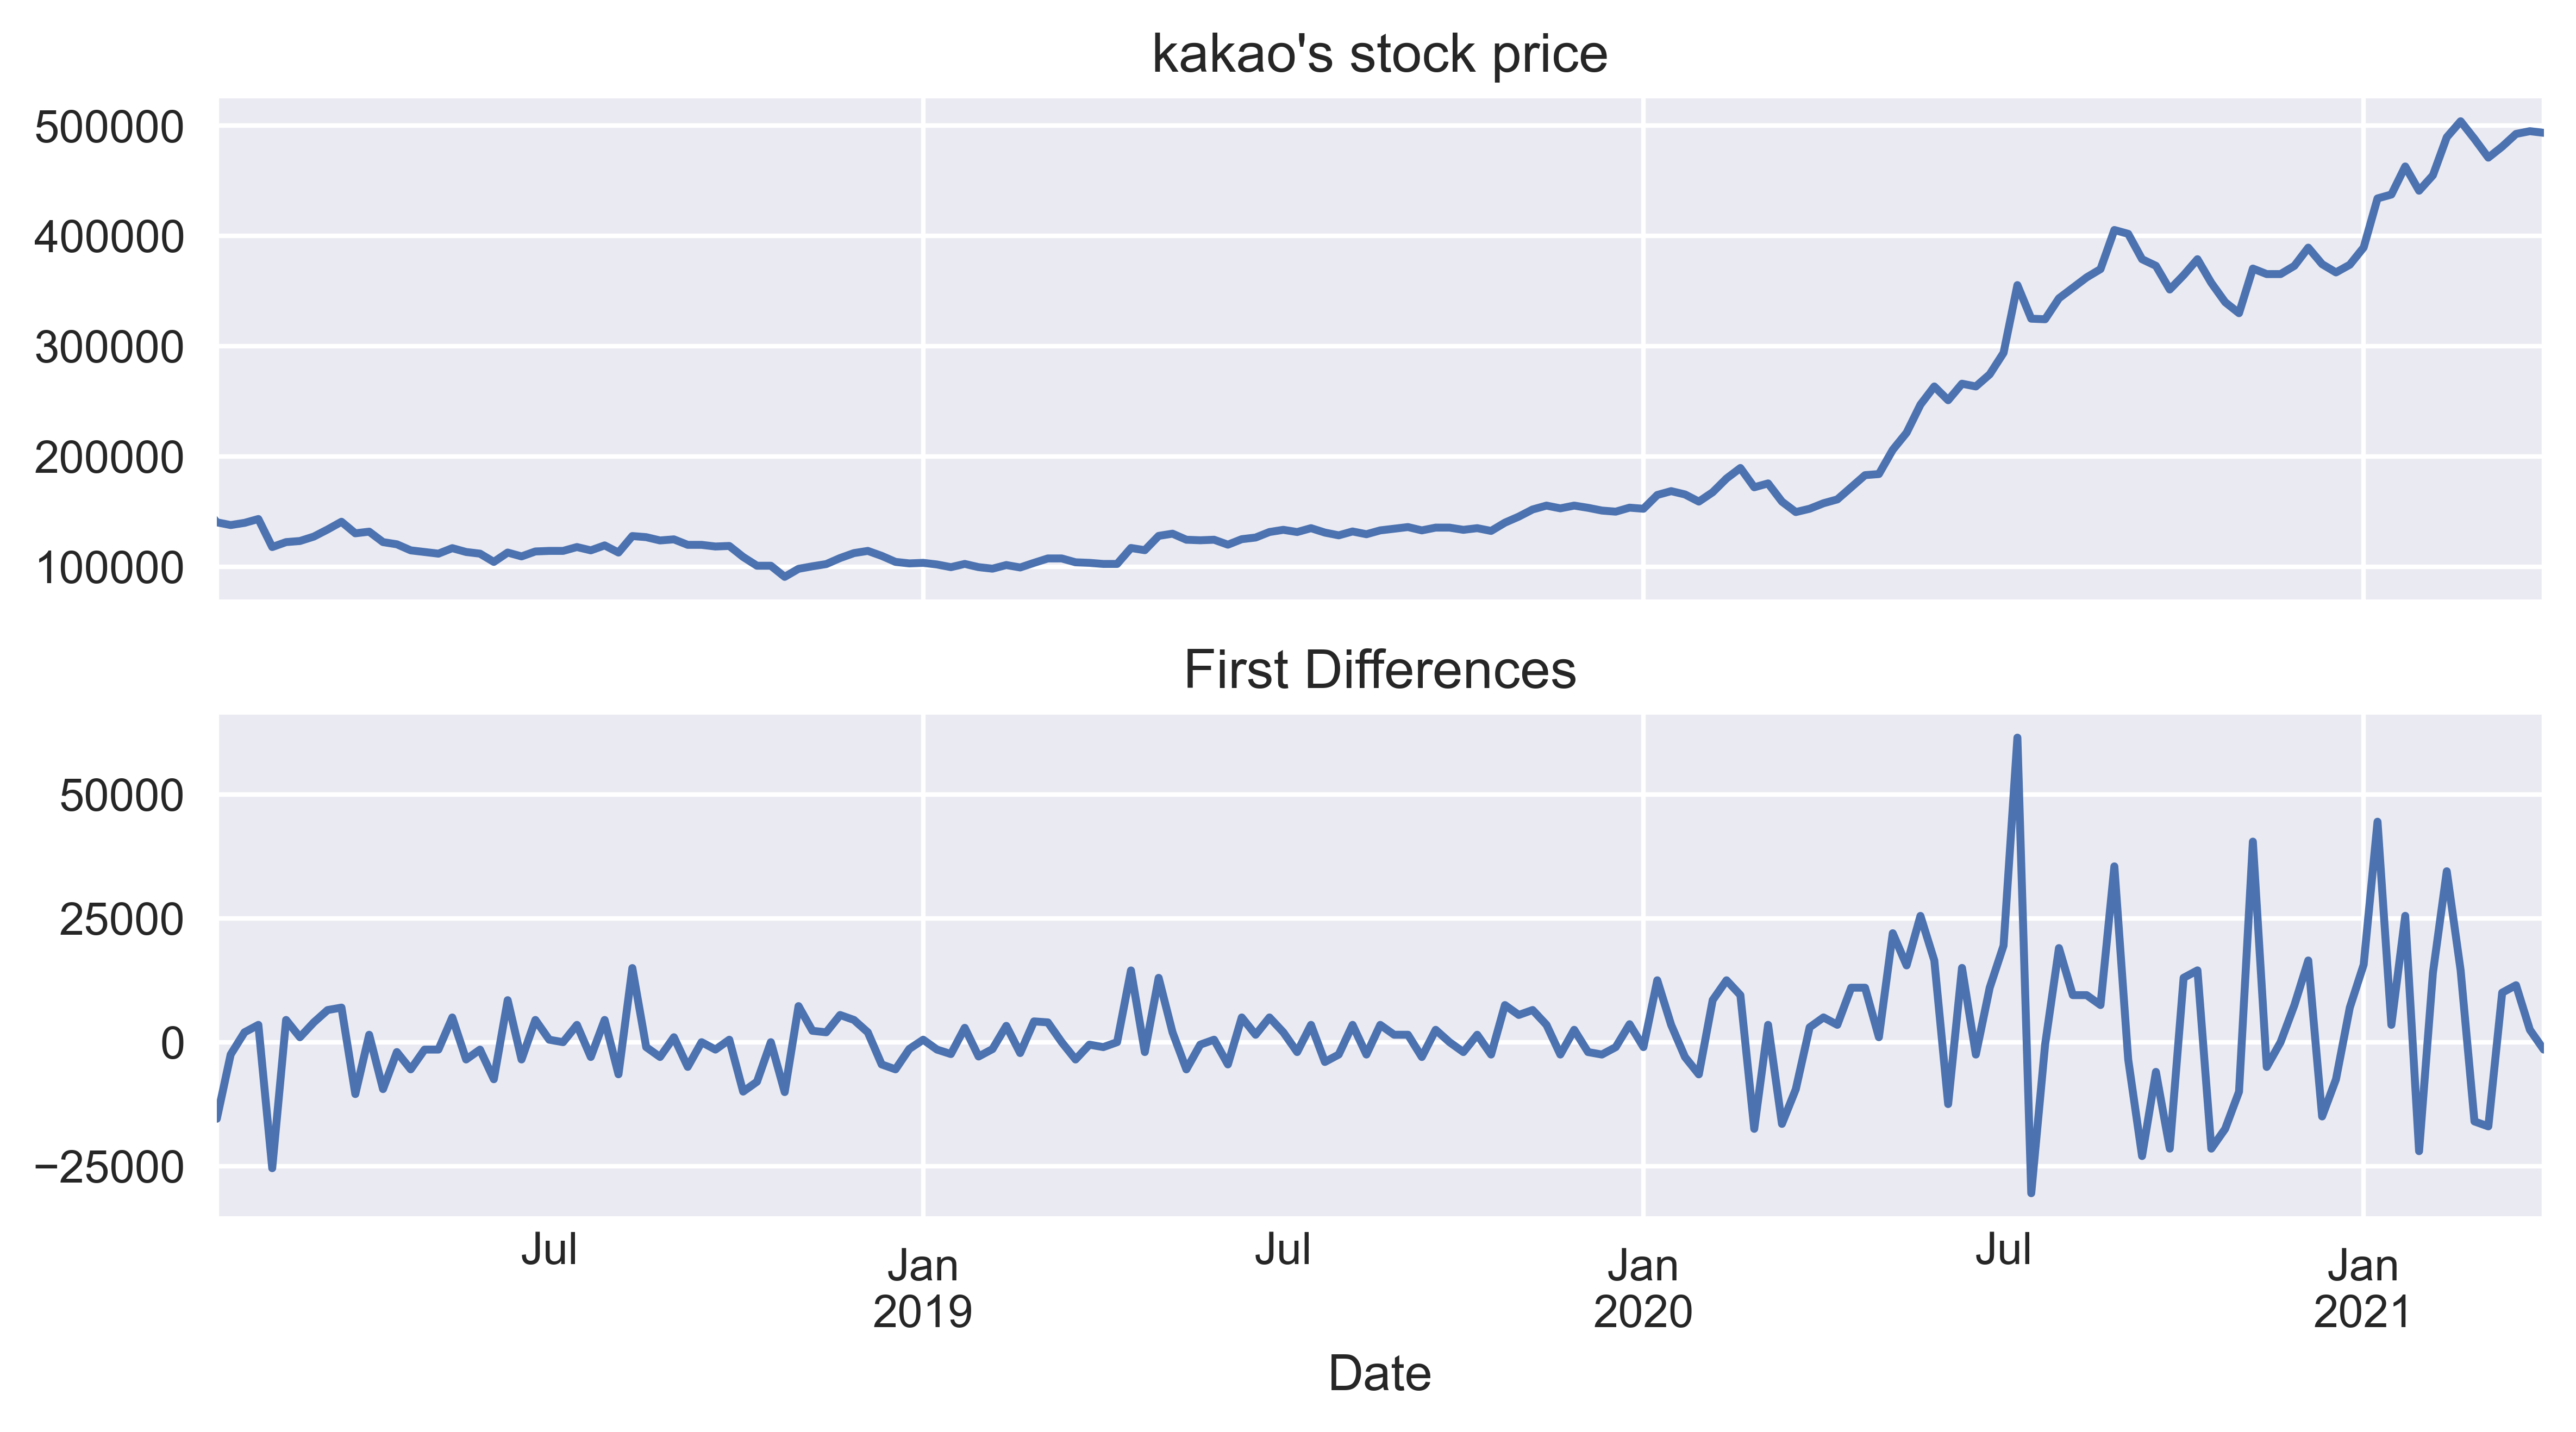

In [35]:
goog_diff = goog.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
goog.plot(title = "kakao's stock price", ax=ax[0])
goog_diff.plot(ax=ax[1], title='First Differences')

plt.tight_layout()
#plt.savefig('images/ch3_im18.png')
plt.show()

ADF test statistic: -2.20 (p-val: 0.21)
KPSS test statistic: 0.62 (p-val: 0.02)


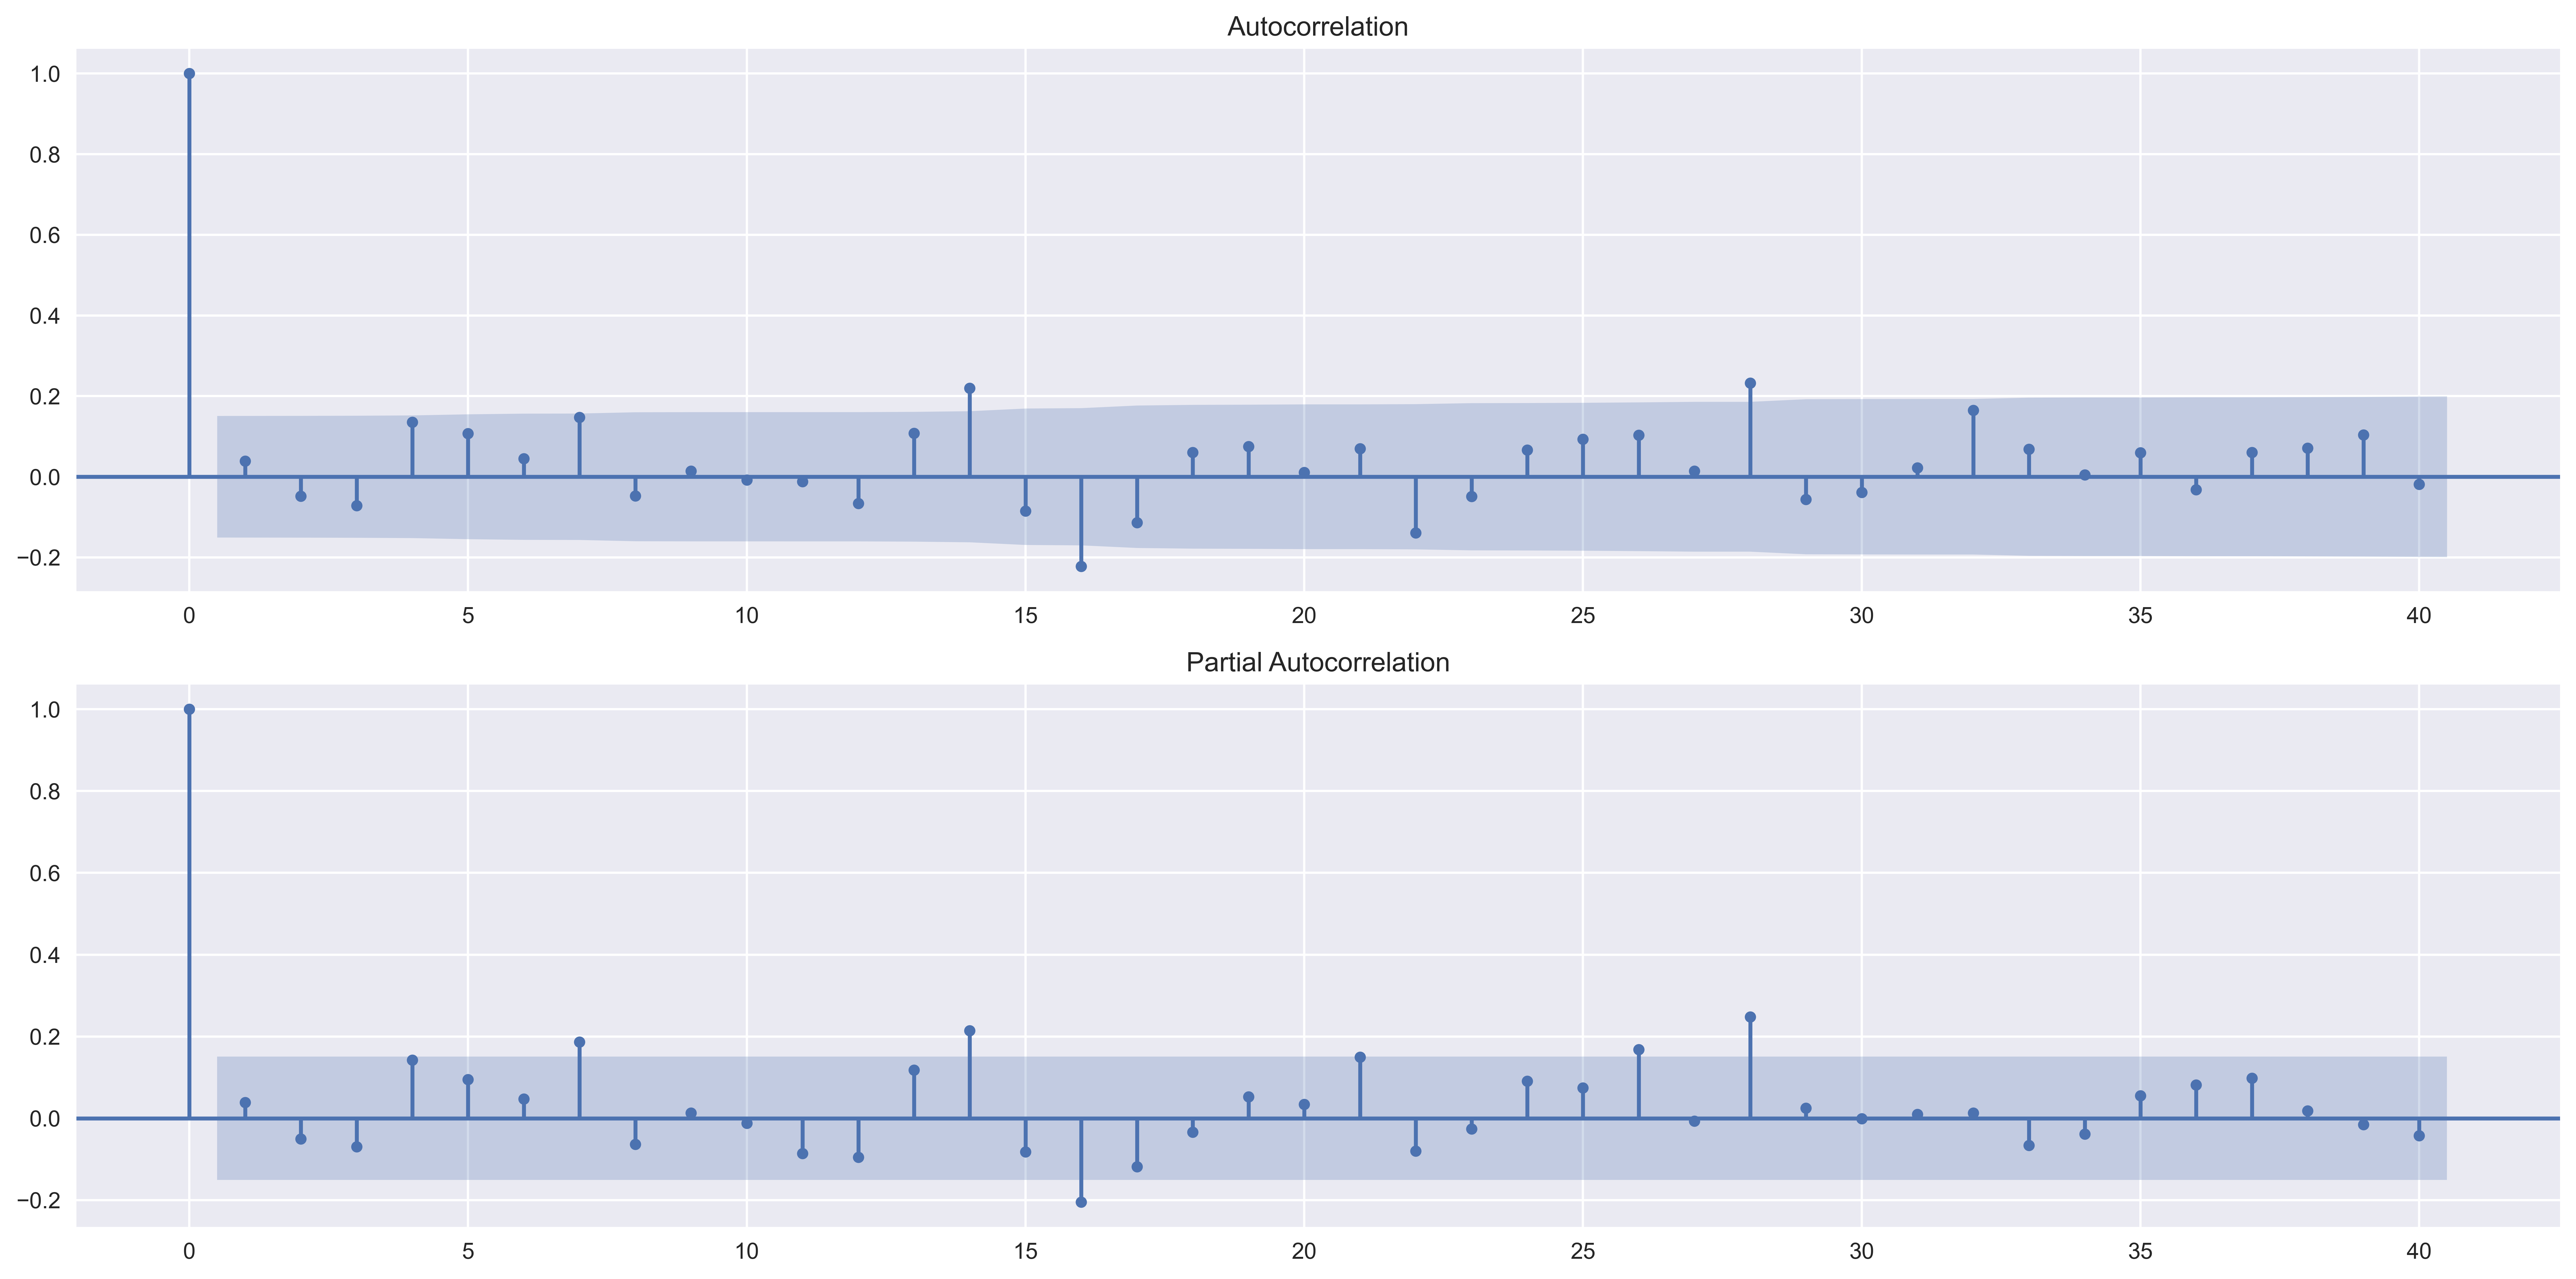

In [36]:
fig = test_autocorrelation(goog_diff)

plt.tight_layout()
#plt.savefig('images/ch3_im19.png')
plt.show()

In [37]:
arima = ARIMA(goog, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  169
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1823.491
Method:                       css-mle   S.D. of innovations          11741.950
Date:                Sat, 03 Apr 2021   AIC                           3656.981
Time:                        17:18:15   BIC                           3672.631
Sample:                    01-14-2018   HQIC                          3663.332
                         - 04-04-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2002.3646    881.355      2.272      0.023     274.940    3729.789
ar.L1.D.adj_close     0.2140      0.484      0.443      0.658      -0.734       1.162
ar.L2.D.adj_close    -0.0618      0.078     -0.790      0.429      -0.215       0.091
ma.L1.D.adj_close    -0.1734      0.479     -0.362      0.717      -1.113       0.766
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7328           -3.6320j            4.0242           -0.1791
AR.2            1.7328           +3.6320j            4.0242            0.1791
MA.1            5.7665           +0.0000j            5.7665            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

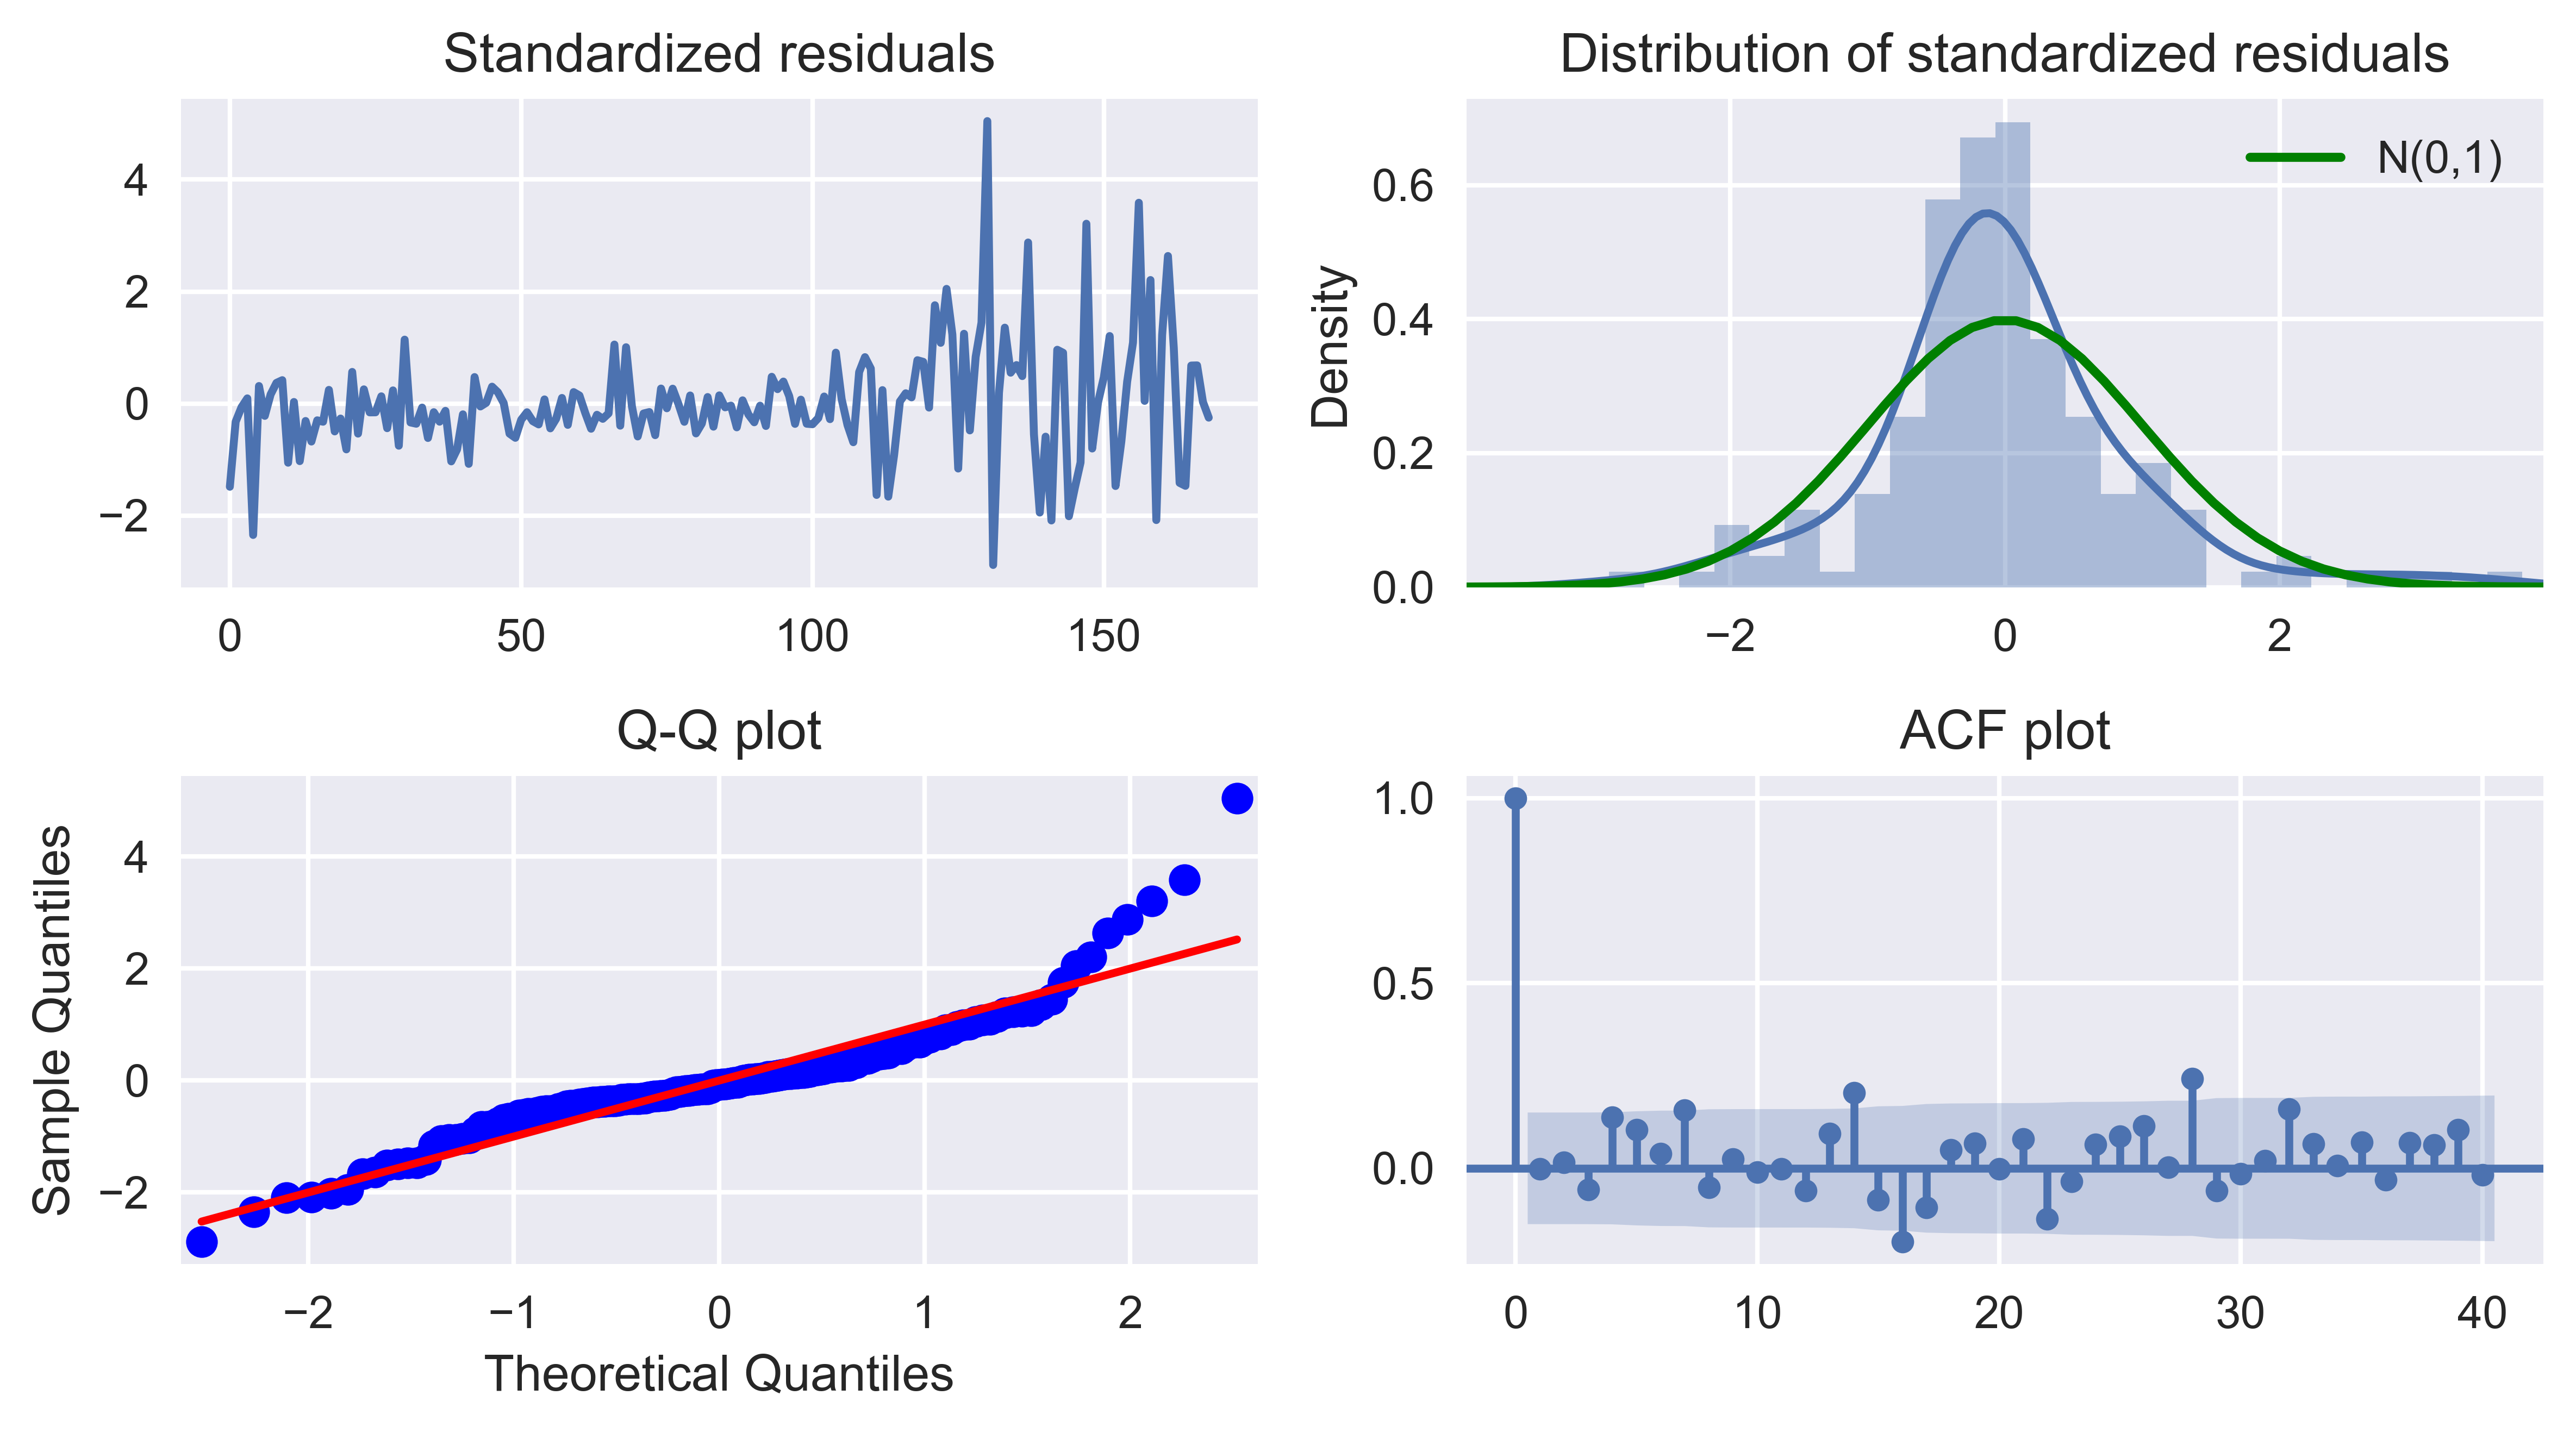

In [39]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
#plt.savefig('images/ch3_im21.png')
plt.show()

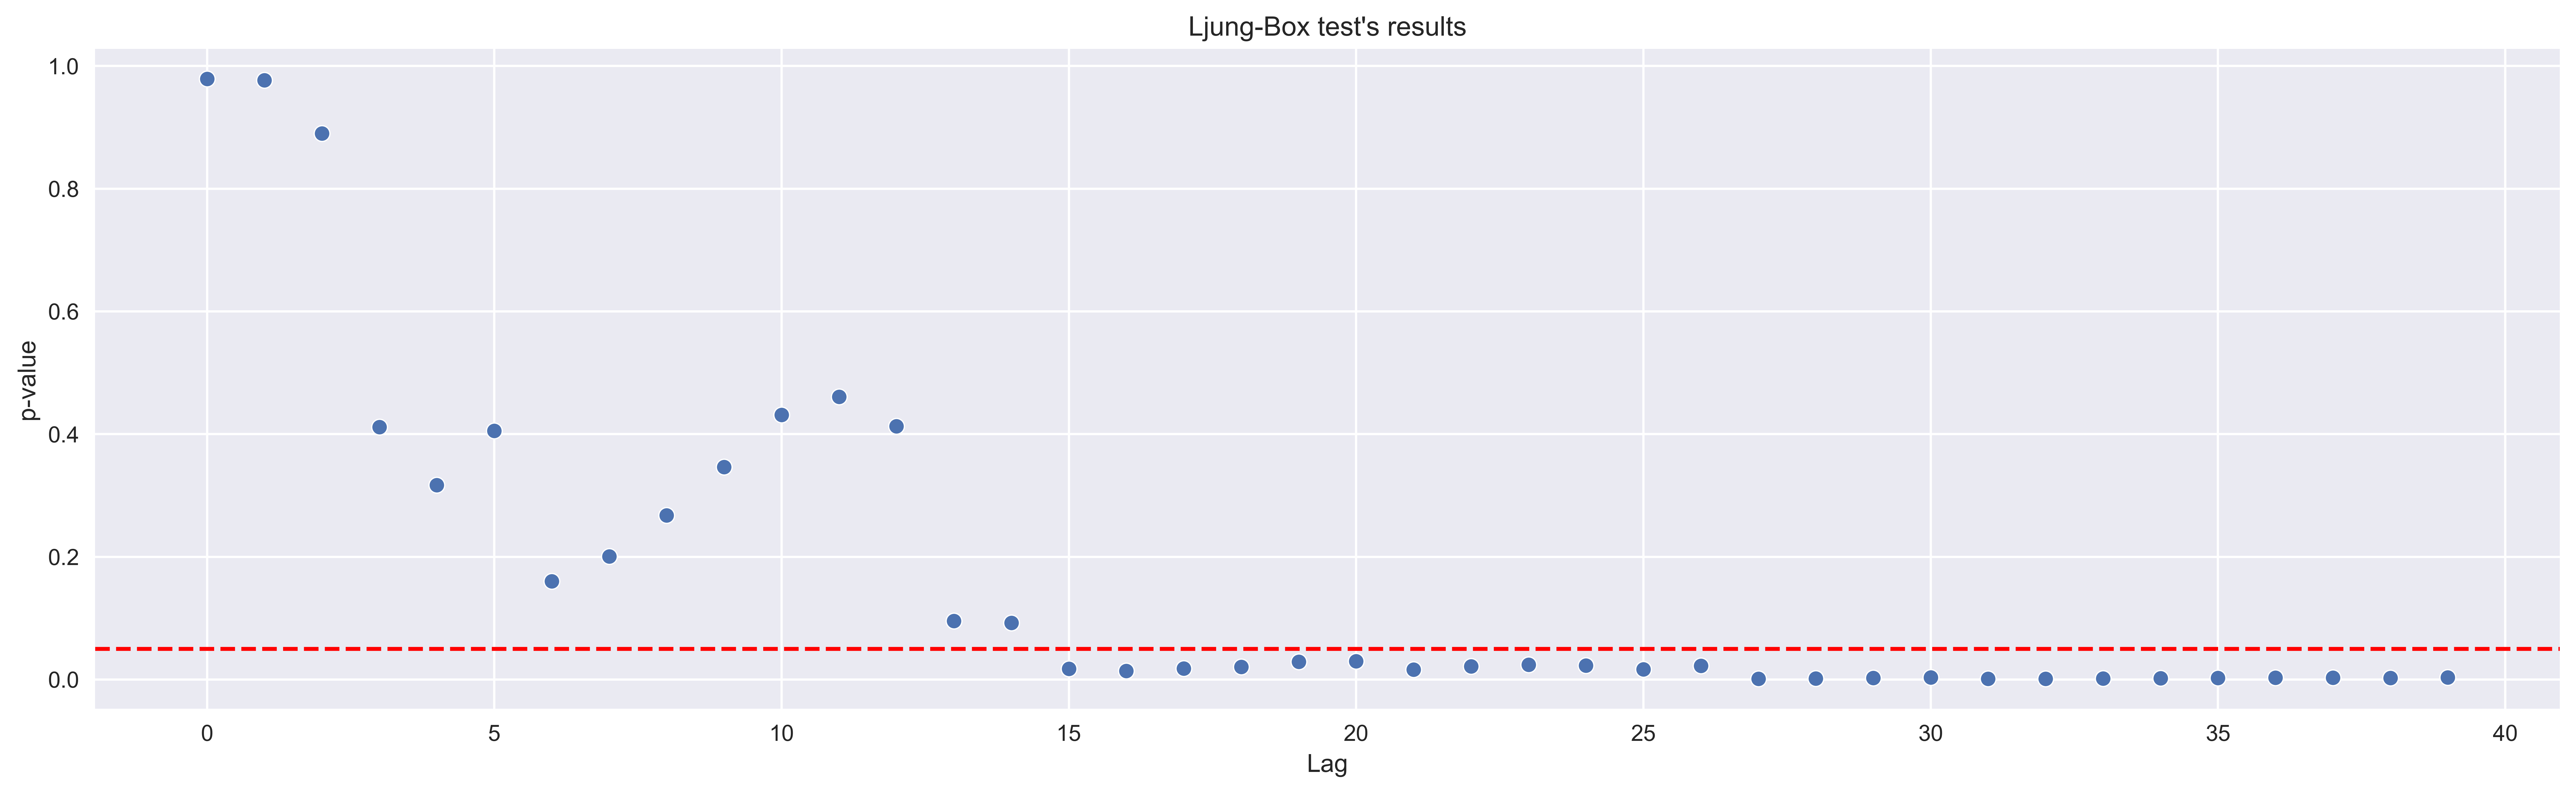

In [40]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
#plt.savefig('images/ch3_im22.png')
plt.show()

In [42]:
pip install pmdarima

     |████████████████████████████████| 610 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 12.3 MB/s eta 0:00:01
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
Note: you may need to restart the kernel to use updated packages.


In [43]:
import pmdarima as pm

In [44]:
auto_arima = pm.auto_arima(goog, 
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  170
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1825.184
Date:                Sat, 03 Apr 2021   AIC                           3658.369
Time:                        17:20:11   BIC                           3670.865
Sample:                             0   HQIC                          3663.440
                                - 170                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2333      0.051      4.584      0.000       0.134       0.333
ar.L2         -0.0842      0.052     -1.607      0.108      -0.187       0.019
ma.L1         -0.9814      0.020    -49.309      0.000      -1.020      -0.942
sigma2      1.638e+08   2.25e-11   7.28e+18      0.000    1.64e+08    1.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               111.48
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.80   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+34. Standard errors may be unstable.
"""

In [45]:
auto_arima = pm.auto_arima(goog,
                           error_action='ignore',
                           suppress_warnings=True,
                           seasonal=False,
                           stepwise=False,
                           approximation=False,
                           n_jobs=-1)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  170
Model:               SARIMAX(1, 2, 4)   Log Likelihood               -1824.604
Date:                Sat, 03 Apr 2021   AIC                           3663.208
Time:                        17:20:35   BIC                           3685.076
Sample:                             0   HQIC                          3672.083
                                - 170                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    115.2585     83.336      1.383      0.167     -48.077     278.594
ar.L1         -0.4003      0.269     -1.487      0.137      -0.928       0.127
ma.L1         -0.3256      0.261     -1.248      0.212      -0.837       0.186
ma.L2         -0.5565      0.181     -3.068      0.002      -0.912      -0.201
ma.L3         -0.1640      0.062     -2.626      0.009      -0.286      -0.042
ma.L4          0.1135      0.045      2.498      0.012       0.024       0.202
sigma2      1.501e+08   2.92e-05   5.14e+12      0.000     1.5e+08     1.5e+08
===================================================================================
Ljung-Box (L1) (Q):                   3.10   Jarque-Bera (JB):                84.39
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               3.84   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+29. Standard errors may be unstable.
"""

In [46]:
df = yf.download('035720.KS',
                 start='2021-01-01',
                 end='2021-03-31',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

test = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

Downloaded 59 rows of data.


In [47]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                   'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

In [48]:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], 
                                columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], 
                                columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, 
                            axis=1).set_index(test.index)

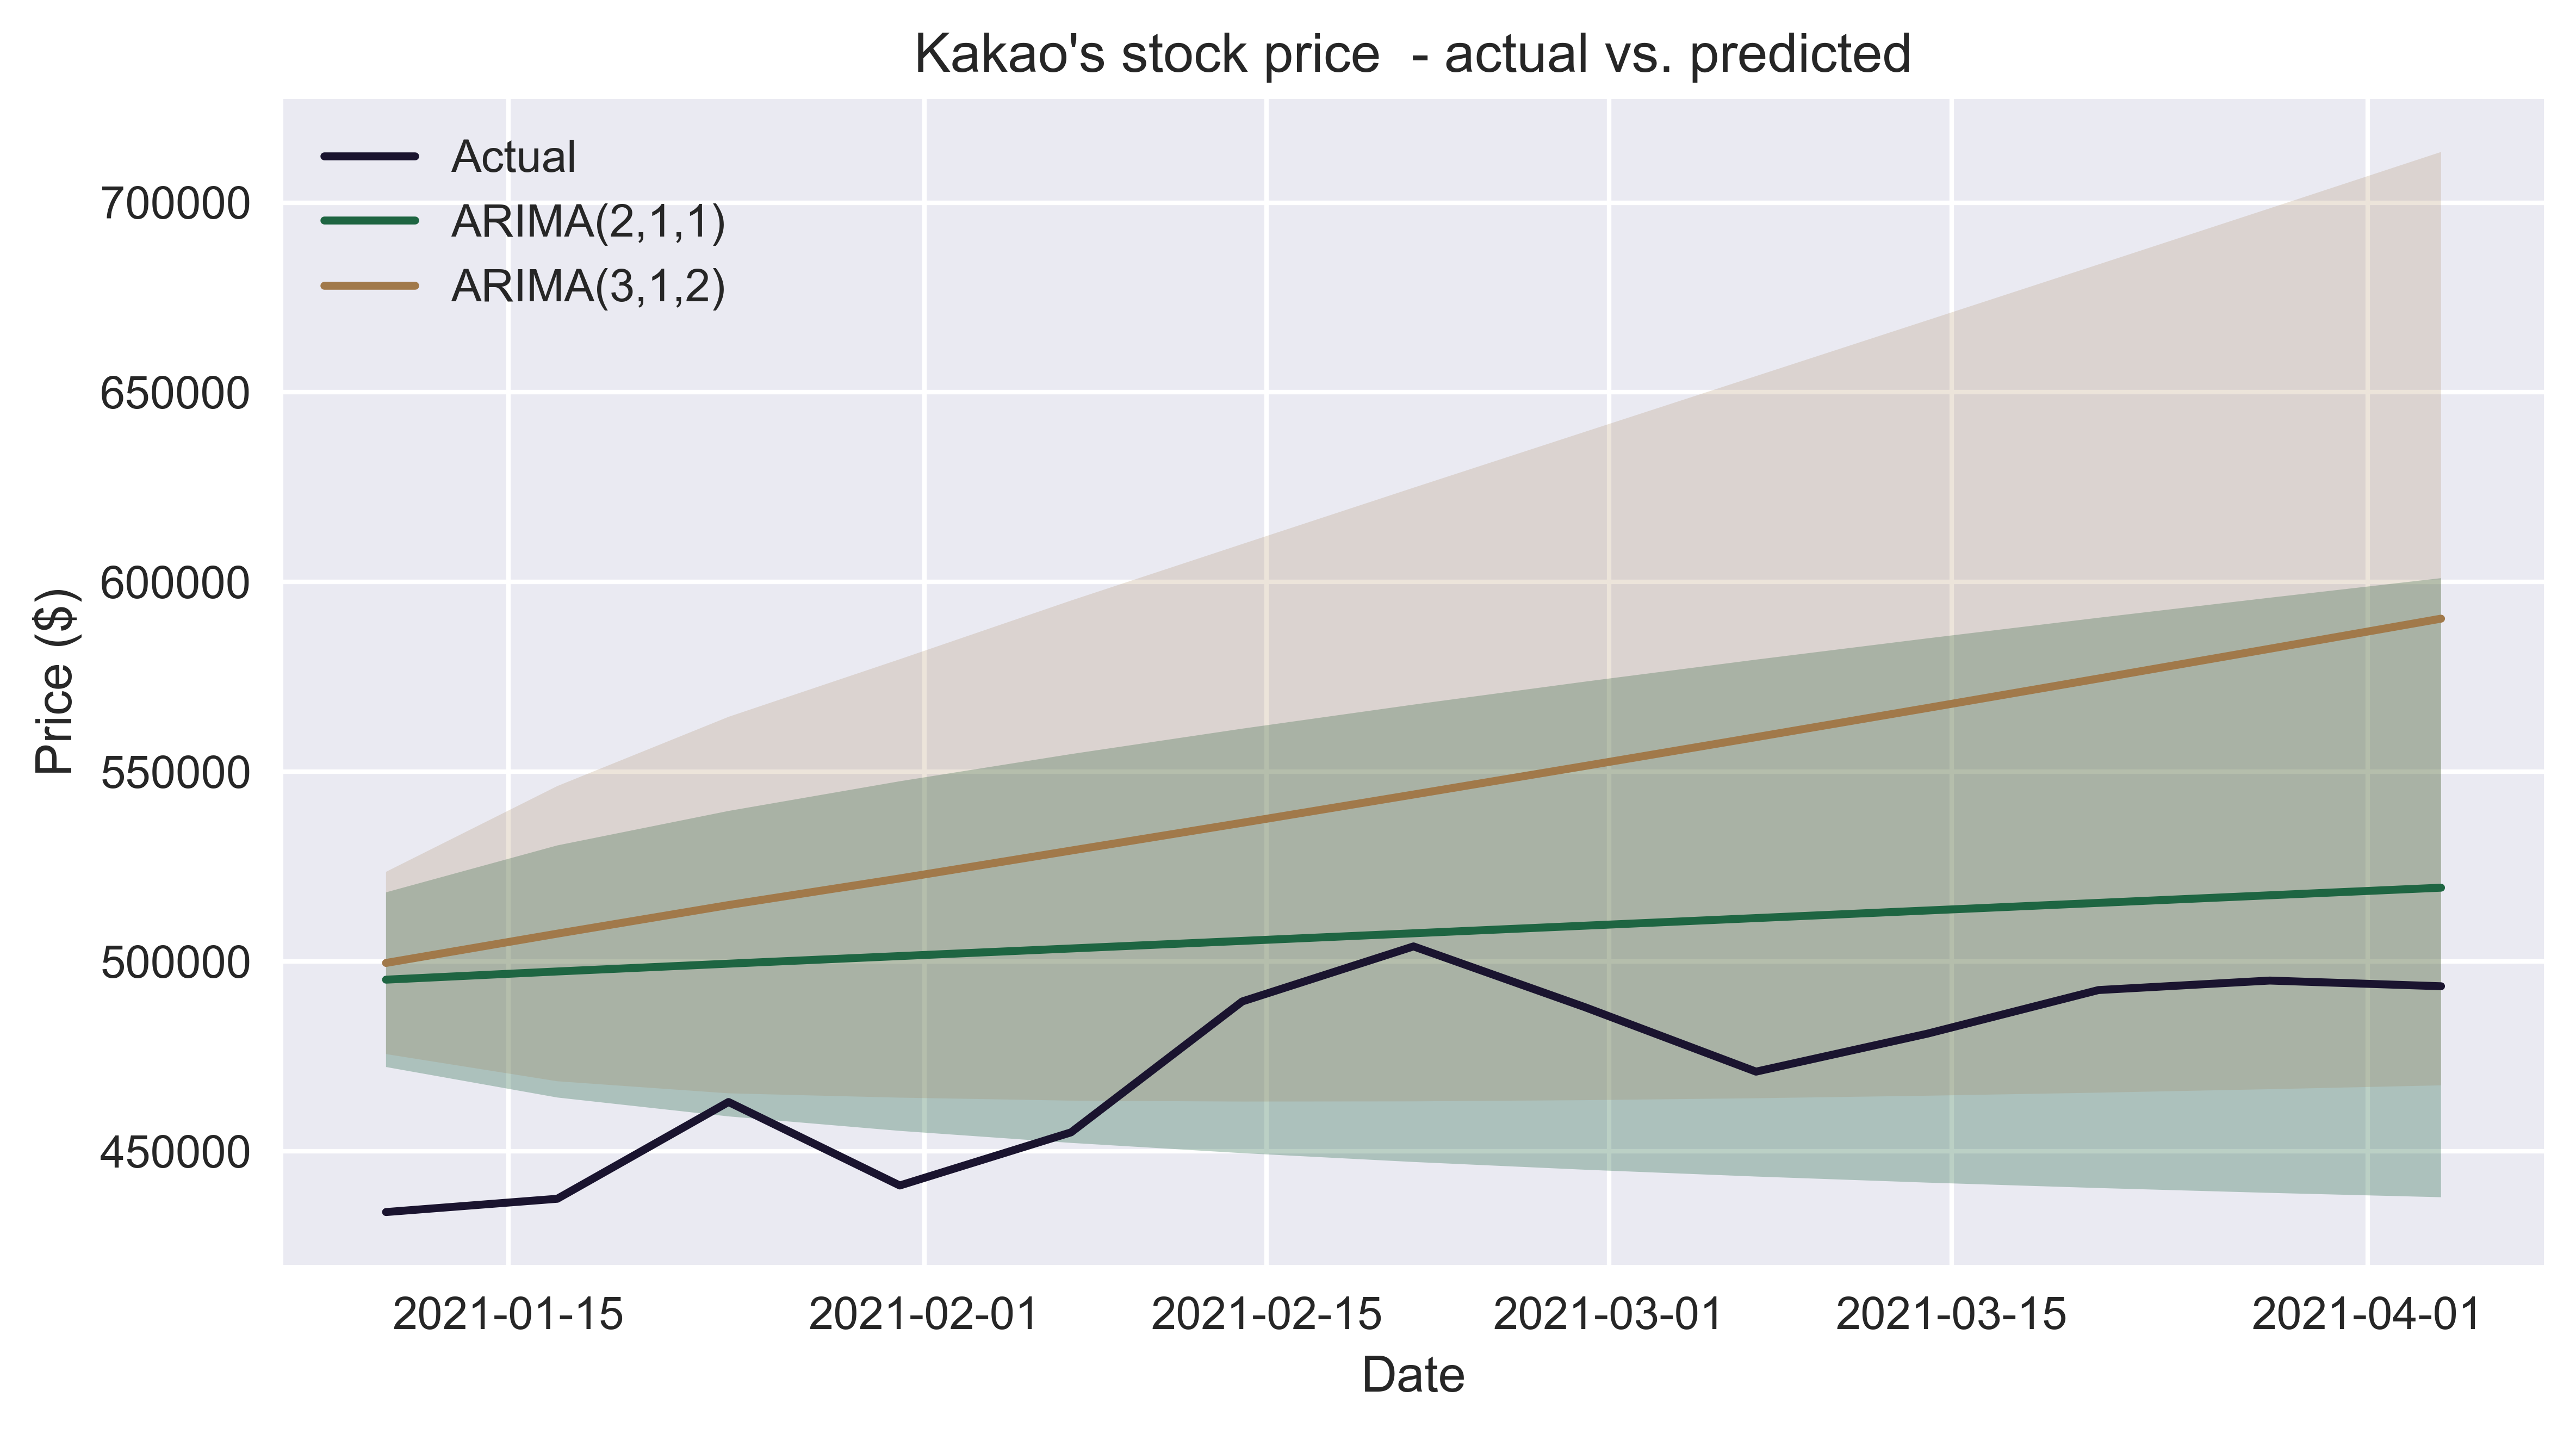

In [50]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], 
        label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index,
                auto_arima_pred.ci_lower,
                auto_arima_pred.ci_upper,
                alpha=0.2, 
                facecolor=COLORS[2])

ax.set(title="Kakao's stock price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/ch3_im25.png')
plt.show()